In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import tensorflow_datasets as tfds
import tensorflow as tf
import keras
from keras import layers

In [3]:
train_ds, val_ds, test_ds = tfds.load("imdb_reviews", split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True) 


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBHCNSK/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBHCNSK/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBHCNSK/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
review, label = next(iter(train_ds)) 
print(review) 
print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [5]:
class cnf:
    VOCAB_SIZE = 10000
    SEQ_LEN = 250 
    EMBED_DIM = 300
    BATCH_SIZE = 64
    SEED = 24
    AUTOTUNE = tf.data.AUTOTUNE
    
tf.random.set_seed(cnf.SEED)
np.random.seed(cnf.SEED)


In [6]:
def standardization(text_line):
    lowercase = tf.strings.lower(text_line) 
    no_tag = tf.strings.regex_replace(lowercase, "<[^>]+>", "") 
    output = tf.strings.regex_replace(no_tag, f"[{re.escape(string.punctuation)}]", "") 
    return output

In [7]:
rev = standardization(review) 
print(rev)

tf.Tensor(b'this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it', shape=(), dtype=string)


In [8]:
vectorize_layer = layers.TextVectorization(
      standardize = standardization,
    max_tokens = cnf.VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = cnf.SEQ_LEN 
)

In [9]:
texts = train_ds.map(lambda x,y : x) 
vectorize_layer.adapt(texts)

In [10]:
def vectorize(review, label):
    return vectorize_layer(review), label 

train_ds = train_ds.map(vectorize) 
val_ds = val_ds.map(vectorize) 



In [11]:
vectorize_layer.get_vocabulary()[:20]

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'this',
 'i',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film']

In [12]:
train_ds = train_ds.batch(cnf.BATCH_SIZE).prefetch(cnf.AUTOTUNE)
val_ds = val_ds.batch(cnf.BATCH_SIZE).prefetch(cnf.AUTOTUNE)

<h3> Simple RNN </h3>

In [13]:
model = keras.Sequential([
    layers.Input(shape=(cnf.SEQ_LEN,)),
    layers.Embedding(cnf.VOCAB_SIZE, cnf.EMBED_DIM), 
    layers.SimpleRNN(32),
    layers.Dense(1, activation='sigmoid')
])

model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │        10,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,010,689 (11.48 MB)

 Trainable params: 3,010,689 (11.48 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
rnn_model = "rnn.keras"
model_callback = keras.callbacks.ModelCheckpoint(
    filepath = rnn_model,
    save_best_only=True,
    monitor='val_accuracy',
    mode = 'max'
)

def step_decay(epoch):
    initial_lr = 0.001 
    drop = 0.5 
    epochs_drop = 10.0   
    lr = initial_lr * (drop ** (epoch // epochs_drop)) 
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay) 

model.compile(
 loss= keras.losses.BinaryCrossentropy(),
 optimizer = keras.optimizers.Adam(learning_rate=1e-3),
 metrics = ['accuracy']
)

history = model.fit(
train_ds, 
validation_data = val_ds, 
epochs = 5, 
callbacks = [model_callback, lr_scheduler]
)

Epoch 1/5
  3/391 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5425 - loss: 0.6896

I0000 00:00:1720249160.140739     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720249160.178994     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5048 - loss: 0.6961 - val_accuracy: 0.5018 - val_loss: 0.6972 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6055 - loss: 0.6277 - val_accuracy: 0.5026 - val_loss: 0.7300 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6479 - loss: 0.5350 - val_accuracy: 0.5031 - val_loss: 0.8274 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6671 - loss: 0.4856 - val_accuracy: 0.5036 - val_loss: 0.8910 - learning_rate: 0.0010
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6699 - loss: 0.4767 - val_accuracy: 0.5021 - val_loss: 0.9260 - learning_rate: 0.0010


In [19]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 

plt.title("model accuracy") 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='best') 

plt.show()

AttributeError: 'dict' object has no attribute 'history'

<h3> LSTM </h3>

In [16]:
model = keras.models.Sequential([
    layers.Input(shape=(cnf.SEQ_LEN,)),
    layers.Embedding(cnf.VOCAB_SIZE, cnf.EMBED_DIM),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 250, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,321 (12.33 MB)

 Trainable params: 3,232,321 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
lstm_file_path = "lstm_model.keras" 
model.compile(loss= keras.losses.BinaryCrossentropy(),
             optimizer = keras.optimizers.Adam(1e-4), 
              metrics=['accuracy']
             )

model_checkpoint = keras.callbacks.ModelCheckpoint(
filepath = lstm_file_path, monitor='val_accuracy', save_best_only=True 
)
history = model.fit(
train_ds, 
    validation_data = val_ds, 
    epochs=10,
    callbacks = [model_checkpoint]
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.5567 - loss: 0.6743 - val_accuracy: 0.8150 - val_loss: 0.4179
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8479 - loss: 0.3746 - val_accuracy: 0.8550 - val_loss: 0.3655
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9018 - loss: 0.2683 - val_accuracy: 0.8569 - val_loss: 0.3813
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9269 - loss: 0.2117 - val_accuracy: 0.8478 - val_loss: 0.4575
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9387 - loss: 0.1829 - val_accuracy: 0.8503 - val_loss: 0.4335
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9479 - loss: 0.1611 - val_accuracy: 0.8448 - val_loss: 0.4254
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9488 - loss: 0.1504 - val_accuracy: 0.8317 - val_loss: 0.4823
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9480 - loss: 0.1467 - 

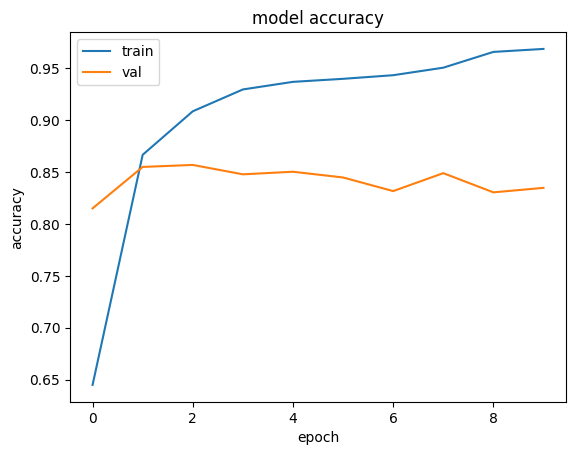

In [23]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 

plt.title("model accuracy") 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='best') 

plt.show()

<h3> GRU </h3>

In [26]:
model = keras.models.Sequential([
    layers.Input(shape=(cnf.SEQ_LEN,)),
    layers.Embedding(cnf.VOCAB_SIZE, cnf.EMBED_DIM),
    layers.Bidirectional(layers.GRU(64, return_sequences=True)),
    layers.Bidirectional(layers.GRU(32)),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 250, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 250, 128)       │       140,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,175,873 (12.11 MB)

 Trainable params: 3,175,873 (12.11 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
x = np.random.rand(8,10,20)

bi = layers.Bidirectional(layers.GRU(16, return_sequences=True)) 
y = bi(x) 
y.shape

TensorShape([8, 10, 32])

In [34]:
gru_file_path = "gru_model.keras" 
model.compile(loss= keras.losses.BinaryCrossentropy(),
             optimizer = keras.optimizers.Adam(1e-4), 
              metrics=['accuracy']
             )

model_checkpoint = keras.callbacks.ModelCheckpoint(
filepath = gru_file_path, monitor='val_accuracy', save_best_only=True 
)
history = model.fit(
train_ds, 
    validation_data = val_ds, 
    epochs=10,
    callbacks = [model_checkpoint]
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.5336 - loss: 0.6891 - val_accuracy: 0.7595 - val_loss: 0.4945
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8295 - loss: 0.3987 - val_accuracy: 0.8586 - val_loss: 0.3411
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9068 - loss: 0.2543 - val_accuracy: 0.8553 - val_loss: 0.3637
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9291 - loss: 0.2007 - val_accuracy: 0.8564 - val_loss: 0.3999
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9405 - loss: 0.1716 - val_accuracy: 0.8524 - val_loss: 0.4311
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9423 - loss: 0.1650 - val_accuracy: 0.8392 - val_loss: 0.4524
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9413 - loss: 0.1642 - val_accuracy: 0.8458 - val_loss: 0.4377
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9474 - loss: 0.1488 - 

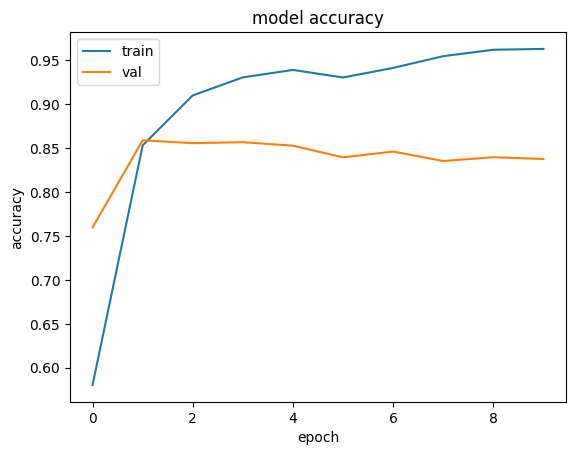

In [35]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 

plt.title("model accuracy") 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='best') 

plt.show()

<h3> Convolutional Model </h3>

In [38]:
model = keras.models.Sequential([
    layers.Input(shape=(cnf.SEQ_LEN,)),
    layers.Embedding(cnf.VOCAB_SIZE, cnf.EMBED_DIM),
    layers.Conv1D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') 
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 250, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 248, 32)        │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │       253,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
conv_file_path = "conv_model.keras" 
model.compile(loss= keras.losses.BinaryCrossentropy(),
             optimizer = keras.optimizers.Adam(1e-4), 
              metrics=['accuracy']
             )

model_checkpoint = keras.callbacks.ModelCheckpoint(
filepath = conv_file_path, monitor='val_accuracy', save_best_only=True 
)
history = model.fit(
 train_ds,
   
    epochs=10,
    callbacks = [model_checkpoint]
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/flatten_1/Reshape defined at (most recent call last):
<stack traces unavailable>
only one input size may be -1, not both 0 and 1

Stack trace for op definition: 
File "opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
File "opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
File "opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
File "opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
File "opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
File "opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
File "opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "tmp/ipykernel_34/3193679602.py", line 10, in <module>
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/models/sequential.py", line 209, in call
File "opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py", line 202, in call
File "opt/conda/lib/python3.10/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph
File "opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py", line 592, in call
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call
File "opt/conda/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 4415, in reshape
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 1778, in reshape

	 [[{{node sequential_4_1/flatten_1/Reshape}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_1885075[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_1885136]